In [1]:
import sys
sys.path.insert(1, '/blue/emackie/nathanschoedl/GlacierStats')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
from skgstat import models
from gstatsim_torch import *
import parallel_torch as gs_pt
import torch
import math

In [2]:
import cProfile, pstats, io

In [3]:
torch.cuda.is_available()

True

In [4]:
df_bed = pd.read_csv('../demos/data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

In [5]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 500
df_grid, torch_data, rows, cols = Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
torch_data = torch_data[torch_data[:,2].isnan() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data)

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']
torch_data[:,2] = torch.tensor(df_grid['Nbed'].to_numpy())

maxlag = 50000             # maximum range distance
n_lags = 70                # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'
V1.parameters

[np.float64(28586.633976966652), np.float64(0.6963988472626428), 0]

In [6]:
# define coordinate grid
xmin = torch.min(torch_data[:,0]); xmax = torch.max(torch_data[:,0])     # min and max x values
ymin = torch.min(torch_data[:,1]); ymax = torch.max(torch_data[:,1])     # min and max y values

Pred_grid_xy = Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [7]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
vtype = 'Exponential'

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, vtype]


k = 100         # number of neighboring data points used to estimate a given point
rad = 50000     # 50 km search radius

In [8]:
# est_SK is the estimate and var_SK is the variance
with cProfile.Profile() as pr:
    est_SK, var_SK = Interpolation.skrige(Pred_grid_xy, torch_data, k, vario, rad)

100%|██████████| 90000/90000 [04:22<00:00, 342.81it/s]


In [10]:
stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

         5968457 function calls (5968454 primitive calls) in 267.271 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    82184   89.631    0.001   89.631    0.001 {built-in method torch._C._linalg.linalg_lstsq}
    82184   87.915    0.001  109.066    0.001 /blue/emackie/nathanschoedl/GlacierStats/gstatsim_torch.py:307(nearest_neighbor_search)
        1   15.226   15.226  267.271  267.271 /blue/emackie/nathanschoedl/GlacierStats/gstatsim_torch.py:738(skrige)
    82184   12.471    0.000   12.471    0.000 {built-in method torch.cdist}
   164368    5.482    0.000    7.022    0.000 /blue/emackie/nathanschoedl/GlacierStats/gstatsim_torch.py:630(covar)
    82184    5.193    0.000    5.193    0.000 {built-in method torch.argsort}
   328738    4.394    0.000    4.394    0.000 {method 'to' of 'torch._C.TensorBase' objects}
    82186    4.386    0.000    4.733    0.000 {built-in method torch.tensor}
   246552    4.223    0.000    4.22

In [7]:
# reverse normal score transformation

var_SK[var_SK < 0] = 0      # make sure variances are non-negative
std_SK = np.sqrt(var_SK)    # convert to standard deviation before back transforming

# reshape
est = est_SK.reshape(-1,1)
std = std_SK.reshape(-1,1)

# back transformation
spred_trans = nst_trans.inverse_transform(est)
sstd_trans = nst_trans.inverse_transform(std)
sstd_trans = sstd_trans - np.min(sstd_trans)

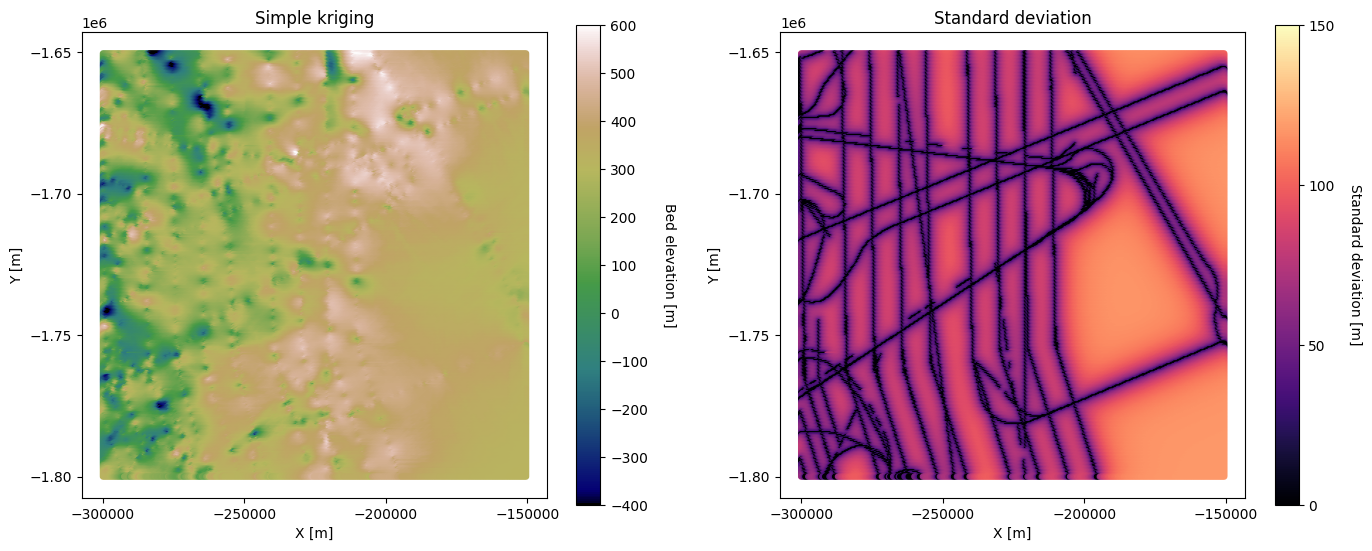

In [8]:
# plot simple kriging and standard deviation
fig = plt.figure()
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = spred_trans, vmin = -400, vmax = 600, marker=".", s = 50,
                cmap = 'gist_earth')       # scatter plot for location map
plt.title('Simple kriging')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sstd_trans, vmin = 0, vmax = 150, marker=".", s = 50,
                cmap = 'magma')       # scatter plot for location map
plt.title('Standard deviation')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 250, 6)) # add vertical color bar
cbar.set_label("Standard deviation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

In [9]:
est_OK, var_OK = Interpolation.okrige(Pred_grid_xy, torch_data, k, vario, rad) # estimation and variance

# reverse normal score transformation
var_OK[var_OK < 0] = 0; # make sure variances are non-negative
std_OK = np.sqrt(var_OK) # convert to standard deviation (this should be done before back transforming!!!)

# reshape
est = est_OK.reshape(-1,1)
std = std_OK.reshape(-1,1)

# back transformation
pred_trans = nst_trans.inverse_transform(est)
std_trans = nst_trans.inverse_transform(std)
std_trans = std_trans - np.min(std_trans)

100%|██████████| 90000/90000 [04:34<00:00, 328.12it/s]


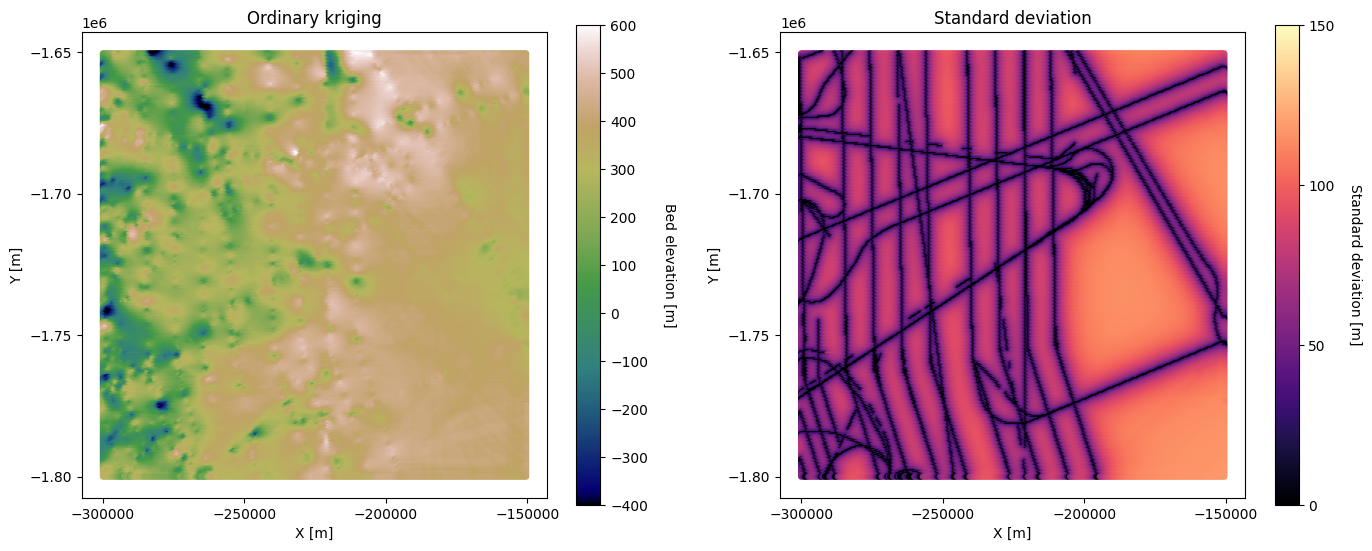

In [10]:
# plot ordinary kriging and stnadard deviation
fig = plt.figure()
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = pred_trans, vmin = -400, vmax = 600, marker=".", s = 50,
                cmap = 'gist_earth')       # scatter plot for location map
plt.title('Ordinary kriging')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = std_trans, vmin = 0, vmax = 150, marker=".", s = 50,
                cmap = 'magma')       # scatter plot for location map
plt.title('Standard deviation')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 250, 6)) # add vertical color bar
cbar.set_label("Standard deviation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

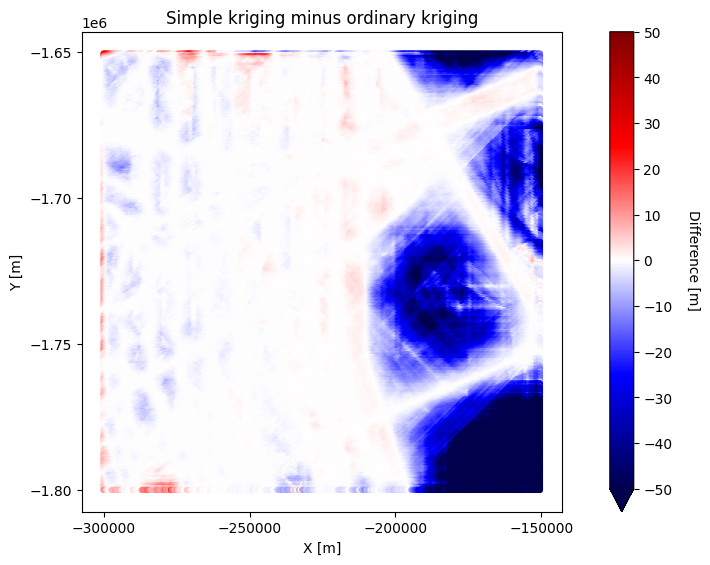

In [11]:
# plot difference
fig = plt.figure()
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = spred_trans - pred_trans, vmin = -50, vmax = 50, 
                 marker=".", s = 50, cmap = 'seismic')       # scatter plot for location map
plt.title('Simple kriging minus ordinary kriging')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-50, 50, 11), extend='min') # add vertical color bar
cbar.set_label("Difference [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show()

In [12]:
sgs=Interpolation.skrige_sgs(Pred_grid_xy, torch_data, k, vario, rad)

100%|██████████| 90000/90000 [04:41<00:00, 319.15it/s]


In [13]:
reduced = sgs[len(torch_data):,:]

In [14]:
index_sort = torch.zeros(len(Pred_grid_xy), dtype=int)

for i in range(len(Pred_grid_xy)):
    index_sort[i] = torch.argwhere(torch.sum(reduced[:, :2] == Pred_grid_xy[i], axis = 1) == 2)
    
reduced = reduced[index_sort]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
reduced_cpu = reduced.cpu().numpy()
sim1 = reduced_cpu[:,2].reshape(-1,1)
sim_trans = nst_trans.inverse_transform(sim1)

In [ ]:
x = reduced_cpu[:,0].reshape(-1,1)
y = reduced_cpu[:,1].reshape(-1,1)

In [ ]:
# make hillshade for visualizing
vmin = -400; vmax = 600
x_mat = x.reshape((rows, cols))
y_mat = y.reshape((rows, cols))
mat = sim_trans.reshape((rows, cols))
xmin = x.min(); xmax = x.max()
ymin = y.min(); ymax = y.max()
    
cmap=plt.get_cmap('gist_earth')
fig, ax = plt.subplots(1, figsize=(5,5))
im = ax.pcolormesh(x_mat, y_mat, mat, vmin=vmin, vmax=vmax, cmap=cmap)
    
# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)
        
# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(mat, vert_exag=1, dx=1, dy=1, fraction=1.0)
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='gray', alpha=0.1)
plt.title('SGS Realization')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
ax.axis('scaled')
plt.show()